### Mount Google Drive

In [1]:
# # mount your current Google Drive (Directory)
import os
file = 'MOM4_data.csv'

''' colab '''
# from google.colab import drive         
# base_path = '/content/drive'
# drive.mount(base_path, force_remount=True)
# data_path = os.path.join(base_path, file)
# result_path = os.path.join(base_path,'My Drive/고영 (5차년도)/model/np/1d_regression_MOM4')

''' local '''
base_path = './'
data_path = os.path.join(base_path,file)    # local

# prepare result directory
result_path = os.path.join(base_path,'result')
if not os.path.isdir(result_path):
    os.makedirs(result_path)

In [2]:
'''
Common
'''

# imports
import shutil
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Read in dataset

In [3]:
'''
Read dataset
'''

# configurations for plots
%matplotlib inline
pd.set_option('display.max_columns', None)

# read data
df = pd.read_csv(data_path  ,index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0
temp = df.copy()
df.head(5)

,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_X1,SPI_Y1,SPI_X2,SPI_Y2,SPI_L1,SPI_W1,SPI_L2,SPI_W2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90,31.26,100.11,81.7355,75.6950,-51.9,63.3,-52.1,60.5,63.3,51.9,60.5,52.1,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90,31.83,100.11,83.1555,71.5083,-45.7,66.1,-48.3,61.3,66.1,45.7,61.3,48.3,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90,32.40,100.11,87.0870,67.2606,-48.6,75.8,-34.6,68.9,75.8,48.6,68.9,34.6,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90,32.97,100.11,80.0433,75.8866,-56.3,65.8,-44.9,60.4,65.8,56.3,60.4,44.9,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90,33.54,100.11,76.7088,74.0452,-48.9,69.7,-51.1,69.2,69.7,48.9,69.2,51.1,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


### Visualize entire PCB board

In [ ]:
# preprocess by crd and job type
group_indices = {}

dfgroups = df.groupby(['PartType','Orient.'])
fig, ax = plt.subplots(figsize=(8,6))
for name, group in dfgroups:
  # name = (name[0][1:], name[1]) # remove R
  ax.plot(group.X, group.Y, marker='o', linestyle='', label=name)
  group_indices[name] = group.index
  
  # visualize each chip block
  # fig2, ax2 = plt.subplots(figsize=(12,8))
  # ax2.scatter(group.X, group.Y, marker='o', label=name)
  # ax2.set_xlim(xmin=min(group.X)-2, xmax=max(group.X)+2)
  # ax2.set_ylim(ymin=min(group.Y)-2, ymax=max(group.Y)+2)
  # ax2.legend(fontsize=10, loc='upper left')
  # plt.tight_layout()

ax.legend(fontsize=10, loc='upper right')
ax.set_title('Pad centerpoints (PartType, orient)', fontsize=11)
ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
plt.tight_layout()
plt.show()

In [0]:
''' CRD: checking how many rows are in each B,C,D chip type '''
df2 = df.copy()
crds = list(df2['CRD'].values)
filter_by_chip = lambda x: [crd for crd in crds if crd[0] == x]
crds_0402 = filter_by_chip('B')
crds_0603 = filter_by_chip('C')
crds_1005 = filter_by_chip('D')
print(f'B: {len(crds_0402)}, C: {len(crds_0603)}, D: {len(crds_1005)}')


### Define chip part type, X and Y features (e.g. *PRE_L*, *POST_L*)
- How do the distributions look?

In [0]:
''' 
preprocessing
    chip_dataframes contains grouped data by part type
    in a dictionary with each part type as the key
'''
# 1. group into chip placement types
chip_dataframes = dict()
for name, group in df2.groupby(['PartType']):
    chip_dataframes[str(name)] = group
# 2. select by part type, xvar, yvar
parttype = 'R1005' # ['R0402', 'R0608', 'R1005']
xvar = 'PRE_W'
yvar = 'POST_W'
data = chip_dataframes[parttype]
all_x_np = data[xvar].values[0:-1].reshape(-1, 1).astype(np.float32)
all_y_np = data[yvar].values[0:-1].reshape(-1, 1).astype(np.float32)

In [0]:
from scipy.stats import norm
# suppress future warning for 'distplot' in seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig = plt.figure(figsize=(18,6))

''' xvar '''
ax = fig.add_subplot(131)
# actual histogram
ax.hist(data[xvar], bins=100, density=True, alpha=0.6, color='b', label="histogram")
# gaussian fitting
mu, std = norm.fit(data[xvar])
x = np.linspace(np.min(data[xvar]), np.max(data[xvar]), 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2, label="gaussian fit")
# distribution envelope tracing
sns.distplot(data[xvar], color='g', label="distribution fit", ax=ax)
ax.set_title(f'{parttype}, {xvar}')
ax.set_xlabel("um")
ax.set_ylabel("Freq")
ax.legend(loc='best')
# plt.show()

''' yvar '''
ax2 = fig.add_subplot(132)
# actual histogram
ax2.hist(data[yvar], bins=30, density=True, alpha=1, color='orange', label="histogram")
# gaussian fitting
mu, std = norm.fit(data[yvar])
x = np.linspace(np.min(data[yvar]), np.max(data[yvar]), 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'k', linewidth=2, label="gaussian fit")
# distribution envelope tracing
sns.distplot(data[yvar], color='g', label="distribution fit", ax=ax2)
ax2.set_title(f'{parttype}, {yvar}')
ax2.set_xlabel("um")
ax2.set_ylabel("Freq")
ax2.legend(loc='best')
# plt.show()

''' 2-D view altogether '''
ax3 = fig.add_subplot(133)
all_x_np = data[xvar].values[0:-1].reshape(-1, 1).astype(np.float32)
all_y_np = data[yvar].values[0:-1].reshape(-1, 1).astype(np.float32)
# plot points
ax3.scatter(all_x_np, all_y_np, label=f'({xvar},{yvar})')
ax3.set_title(f'{parttype}, {xvar}, {yvar}')
ax3.legend(loc='best')
ax3.set_xlabel(xvar)
ax3.set_ylabel(yvar)

plt.show()

### NP: 1 dimensional regression

In [0]:
# utility functions
def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim=0).mean()

def KLD_gaussian(mu_q, std_q, mu_p, std_p):
    var_p = std_p**2 + 1e-10
    var_q = std_q**2 + 1e-10
    return (var_q/var_p + ( (mu_q-mu_p)**2) / var_p + torch.log(var_p/var_q) - 1.0).sum() * 0.5

def random_split_context_target(x, y, n_context):
    ind = np.arange(x.shape[0])
    mask = np.random.choice(ind, size=n_context, replace=False)
    return [x[mask], y[mask], np.delete(x, mask, axis=0), np.delete(y, mask, axis=0)]

def visualize(x, y, x_star, model, epoch, xvar='x', yvar='y'):
    r_z = model.data_to_r(x, y)
    z_mu, z_std = model.r_to_z(r_z)
    zsamples = model.reparametrize(z_mu, z_std, 3)
    mu, sigma = model.decoder(x_star, zsamples)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(mu.size(1)):
        ax.plot(x_star.data.cpu().numpy(), mu[:, i].data.cpu().numpy(), linewidth=1)
        ax.fill_between(
            x_grid[:, 0].data.cpu().numpy(), (mu[:, i] - sigma[:, i]).detach().cpu().numpy(),
            (mu[:, i] + sigma[:, i]).detach().cpu().numpy(), alpha=0.2
        )
        ax.scatter(x.data.cpu().numpy(), y.data.cpu().numpy(), color='b')
        # ax.plot(all_x_np, all_y_np, color='b') # plot all points for comparison
        ax.set_xlabel(xvar)
        ax.set_ylabel(yvar)
    # plt.pause(0.0001)
    fig.canvas.draw()
    fig.savefig(os.path.join(result_path, f'{parttype}_{xvar}_{yvar}_epoch_{str(epoch)}.png'))
    plt.show()


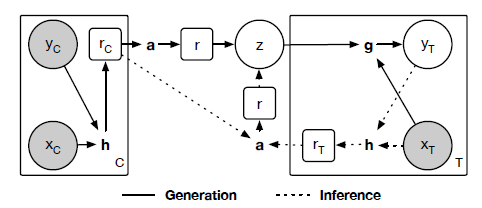

In [1]:
from IPython.display import Image
Image(filename='np.png')


In [0]:
# class definition
class NP(nn.Module):
    def __init__(self, hidden_dim, decoder_dim, z_samples):
        super(NP, self).__init__()
        in_dim = 2  
        out_dim = 2 
        self.z_dim = 2
        self.z_samples = z_samples
        # for data (Xc, Yc) --> representation (r)
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, out_dim)
        # for representation (r) --> latent vector (z)
        self.r_to_z_mu = nn.Linear(in_dim, 1)
        self.r_to_z_std = nn.Linear(in_dim, 1)

        self.decoder1 = nn.Linear(in_dim+1, decoder_dim)
        self.decoder2 = nn.Linear(decoder_dim, out_dim)

        nn.init.normal_(self.hidden1.weight)
        nn.init.normal_(self.hidden2.weight)
        nn.init.normal_(self.decoder1.weight)
        nn.init.normal_(self.decoderx2.weight)

    # data to representations, aggregated
    def data_to_r(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        hidden1 = self.hidden1(x_y) 
        hidden1_activated = F.relu(hidden1)
        r_i = self.hidden2(hidden1_activated)

        # mean aggregate
        r = r_i.mean(dim=0)
        return r

    # representation to latent vector
    def r_to_z(self, r):
        mean = self.r_to_z_mu(r)
        log_var = self.r_to_z_std(r)
        return mean, F.softplus(log_var)

    # reparam trick for tractability in randomness in the input
    def reparametrize(self, mu, std, n):
        eps = torch.autograd.Variable(std.data.new(n, self.z_dim).normal_())
        z = eps.mul(std).add_(mu)
        return z

    # decoder
    def decoder(self, x_pred, z):
        z = z.unsqueeze(-1).expand(z.size(0), z.size(1), x_pred.size(0)).transpose(1, 2)
        x_pred = x_pred.unsqueeze(0).expand(z.size(0), x_pred.size(0), x_pred.size(1))
        x_z = torch.cat([x_pred, z], dim=-1)

        decoded1 = self.decoder1(x_z).squeeze(-1).transpose(0, 1)
        decoder1_activated = torch.sigmoid(decoded1)
        decoded2 = self.decoder2(decoder1_activated)

        mu, logstd = torch.split(decoded2, 1, dim=-1)
        mu = mu.squeeze(-1)
        logstd = logstd.squeeze(-1)
        std = F.softplus(logstd)
        return mu, std

    def forward(self, x_context, y_context, x_target, y_target):
        # make x, y stack
        x_all = torch.cat([x_context, x_target], dim = 0)
        y_all = torch.cat([y_context, y_target], dim = 0)
        
        # context data -> context repr
        r = self.data_to_r(x_context, y_context)    # data -> repr
        z_mean, z_std = self.r_to_z(r)              # repr -> latent z

        # all data -> global repr
        r_all = self.data_to_r(x_all, y_all)
        z_mean_all, z_std_all = self.r_to_z(r_all)all_x_np

        # reparameterize
        zs = self.reparametrize(z_mean_all, z_std_all, self.z_samples)

        # decoder
        mu, std = self.decoder(x_context, zs)
        return mu, std, z_mean_all, z_std_all, z_mean, z_std

In [0]:
# prepare input data (defined in cell above)
def train(epochs, n_context):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        # split into 
        x_context, y_context, x_target, y_target = random_split_context_target(all_x_np, all_y_np, n_context)
        # send to gpu
        x_context = torch.from_numpy(x_context).to(device)
        y_context = torch.from_numpy(y_context).to(device)
        x_target = torch.from_numpy(x_target).to(device)
        y_target = torch.from_numpy(y_target).to(device)
        # forward pass
        mu, std, z_mean_all, z_std_all, z_mean, z_std = model(x_context, y_context, x_target, y_target)
        # loss calculation
        loss = -log_likelihood(mu, std, y_context) + KLD_gaussian(z_mean_all, z_std_all, z_mean, z_std)
        # backprop
        loss.backward()
        training_loss = loss.item()
        optimizer.step()
        print('epoch: {} loss: {}'.format(epoch, training_loss/200))

        # save figure at every 100th training epoch
        if epoch % 1000 == 0:
            visualize(x_context, y_context, torch.from_numpy(vals.reshape(-1, 1).astype(np.float32)).to(device), \
                      model, epoch, xvar, yvar)redict mea
        
        # test with target points
        # TODO

''' data example
    parttype, xvar, yvar = 'R0402', 'PRE_L', 'POST_L'
    all_x_np = chip_dataframes[parttype][xvar].values[0:-1].reshape(-1, 1).astype(np.float32)
    all_y_np = chip_dataframes[parttype][yvar].values[0:-1].reshape(-1, 1).astype(np.float32)
'''
vals = np.arange(min(all_x_np), max(all_x_np), 1e-3)
x_grid = torch.from_numpy(vals.reshape(-1, 1).astype(np.float32))

hidden_dim , decoder_dim, z_samples = 10, 15, 20 # 10, 15, 20
model = NP(hidden_dim , decoder_dim, z_samples).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
# n_context = np.random.randint(20, 30) # a random number between the two numbers
n_context = 20
train(10**5, n_context)

